In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import dask # just to make sure dask is installed because xarray should use it
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm

from utils.metrics import find_rank, find_quantile_index, compute_chi_squared, compute_cdf, compute_sum_of_squared_deviations, compute_nse
from utils.plot import plot_rank_hist, calibration_plot
 
np.set_printoptions(suppress=True)

# Set directory to save results and whether you want to display results in this notebook

In [3]:
SAVE_DIR = Path('/net/argon/landclim/kraftb/machflow_engression/results/engression/')
DISPLAY = True # whether to display plots in notebook (they are saved to files in either case)

# Load Data

In [4]:
ds = xr.open_zarr('/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/')
ds = ds.loc[{'station': ds['folds'] > 0}]

ds = ds[['Qmm', 'Qmm_mod']]
ds

/home/kraftb/.conda/envs/engression/lib/python3.10/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset> Size: 4GB
Dimensions:  (station: 85, time: 4383, beta: 5, esl: 2, nl: 3, member: 100)
Coordinates:
  * beta     (beta) float64 40B 0.33 0.67 1.0 1.33 1.67
  * esl      (esl) int64 16B 1 5
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * nl       (nl) int64 24B 20 5 100
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 35kB 2011-01-01 2011-01-02 ... 2022-12-31
Data variables:
    Qmm      (station, time) float32 1MB dask.array<chunksize=(85, 1000), meta=np.ndarray>
    Qmm_mod  (beta, esl, nl, member, station, time) float32 4GB dask.array<chunksize=(5, 2, 3, 100, 85, 1000), meta=np.ndarray>

In [5]:
observations = ds.Qmm.isel(time=slice(365, None))
observations

<xarray.DataArray 'Qmm' (station: 85, time: 4018)> Size: 1MB
dask.array<getitem, shape=(85, 4018), dtype=float32, chunksize=(85, 1000), chunktype=numpy.ndarray>
Coordinates:
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 32kB 2012-01-01 2012-01-02 ... 2022-12-31

In [6]:
pred = ds.Qmm_mod.isel(time=slice(365, None))
pred

<xarray.DataArray 'Qmm_mod' (beta: 5, esl: 2, nl: 3, member: 100, station: 85,
                             time: 4018)> Size: 4GB
dask.array<getitem, shape=(5, 2, 3, 100, 85, 4018), dtype=float32, chunksize=(5, 2, 3, 100, 85, 1000), chunktype=numpy.ndarray>
Coordinates:
  * beta     (beta) float64 40B 0.33 0.67 1.0 1.33 1.67
  * esl      (esl) int64 16B 1 5
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * nl       (nl) int64 24B 20 5 100
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 32kB 2012-01-01 2012-01-02 ... 2022-12-31

# Run main evaluations and create plots

In [ ]:
results = {}

quantiles = np.arange(start=0.01, stop=1.0, step=0.01)

save_dir_rank_hist = SAVE_DIR / 'rank_histograms'
save_dir_rank_hist.mkdir(exist_ok=True, parents=True)

save_dir_calibration_plot = SAVE_DIR / 'calibration_plots'
save_dir_calibration_plot.mkdir(exist_ok=True, parents=True)
for beta in tqdm(pred.beta):
    for esl in pred.esl:
        for nl in pred.nl:
            results[(beta.data.item(), esl.data.item(), nl.data.item())] = {}
            config_pred = pred.sel(beta=beta, esl=esl, nl=nl)
            
            ranks = xr.apply_ufunc(
                find_rank,
                observations,                       # Observations with ["station", "time"]
                config_pred,                        # Ensemble members with ["member", "station", "time"]
                input_core_dims=[[], ["member"]],   # Observations have no "member" dim, members do
                output_core_dims=[[]],              # Output is scalar per observation
                vectorize=True,                     # Apply function element-wise
                dask="parallelized",                # Enable Dask parallelization if needed
                output_dtypes=[np.int16],           # Output type
            )

            ranks = ranks.compute().data.flatten() # Work with flat numpy array
            ranks = ranks[ranks != -1]
            
            chi_squared = compute_chi_squared(ranks=ranks, num_members=len(config_pred.member))
            results[(beta.data.item(), esl.data.item(), nl.data.item())]['Chi^2'] = chi_squared

            # plot_rank_hist(
            #     ranks=ranks,
            #     title=f'Beta = {beta.data}, ESL = {esl.data}, NL = {nl.data}\n$\chi^2$ = {chi_squared:.2f}',
            #     save_file=save_dir_rank_hist / f'rankhist_beta{beta.data}_esl{esl.data}_nl{nl.data}.eps',
            #     display=DISPLAY
            # ) 


            quantile_values = config_pred.quantile(quantiles, dim='member')
            quantile_indices = xr.apply_ufunc(
                find_quantile_index,
                observations,                       # Observations with ["station", "time"]
                quantile_values,                    # Quantiles with ["quantile", "station", "time"]
                input_core_dims=[[], ["quantile"]], # Observations have no "quantile", quantiles do
                output_core_dims=[[]],              # Output is scalar per observation
                vectorize=True,                     # Apply function element-wise
                dask="parallelized",                # Enable Dask parallelization if needed
                output_dtypes=[np.int16],           # Output type
            )

            quantile_indices = quantile_indices.compute().data.flatten() # Work with flat numpy array
            quantile_indices = quantile_indices[quantile_indices != -1]
            
            cdf_pred = compute_cdf(quantile_indices=quantile_indices, num_quantiles=len(quantiles))
            sum_of_squared_deviations = compute_sum_of_squared_deviations(quantiles, cdf_pred)
            results[(beta.data.item(), esl.data.item(), nl.data.item())]['RSS'] = sum_of_squared_deviations
            nse = compute_nse(config_pred.values, observations.values)
            results[(beta.data.item(), esl.data.item(), nl.data.item())]['NSE'] = nse

            # calibration_plot(
            #     x=quantiles,
            #     cdf_pred=cdf_pred,
            #     title=f'Beta = {beta.data}, ESL = {esl.data}, NL = {nl.data}\nRSS = {sum_of_squared_deviations:.2f}',
            #     x_name='Quantile',
            #     save_file=save_dir_calibration_plot / f'calib_plot_beta{beta.data}_esl{esl.data}_nl{nl.data}.eps',
            #     display=DISPLAY
            # )

  0%|          | 0/5 [00:00<?, ?it/s]

In [1]:
results.keys()

NameError: name 'results' is not defined

In [44]:
res_df = pd.DataFrame(results)
res_df = res_df.sort_index(axis=1)
res_df.to_csv(SAVE_DIR / 'config_results.csv')
res_df

0.33                                                         \
                  1                                        5                 
                5             20           100           5             20    
Chi^2  31687.379912  32232.778786  7742.929615  47323.866343  29379.589022   
RSS        0.573340      0.520069     0.122590      0.838890      0.620268   
NSE        0.573340      0.520069     0.122590      0.838890      0.620268   

                            0.67                                            \
                               1                                         5   
                100          5             20            100           5     
Chi^2  46132.555521  8830.127724  32118.301036  29251.798596  19206.251945   
RSS        0.876555     0.045677      0.834721      0.455605      0.187741   
NSE        0.876555     0.045677      0.834721      0.455605      0.187741   

       ...          1.33                                            \
       ...             1             5                               
       ...           100           5             20            100   
Chi^2  ...  16470.562253  10409.845051  51070.009472  38401.523077   
RSS    ...      0.415247      0.213110      1.339253      0.676963   
NSE    ...      0.415247      0.213110      1.339253      0.676963   

               1.67                                                          \
                  1                                         5                 
                5             20            100           5             20    
Chi^2  11991.329894  27489.494303  13069.341309  21457.686828  42518.699848   
RSS        0.165482      0.539497      0.189679      0.475074      1.106192   
NSE        0.165482      0.539497      0.189679      0.475074      1.106192   

                     
                     
                100  
Chi^2  19346.325478  
RSS        0.370220  
NSE        0.370220  

[3 rows x 30 columns]

In [17]:
res_df = pd.read_csv(SAVE_DIR / 'config_results.csv', index_col=0, header=[0, 1, 2])
res_df

0.33                                                         \
                  1                                        5                 
                  5            20          100             5            20   
Chi^2  31687.379912  32232.778786  7742.929615  47323.866343  29379.589022   
RSS        0.573340      0.520069     0.122590      0.838890      0.620268   

                            0.67                                            \
                               1                                         5   
                100            5            20           100             5   
Chi^2  46132.555521  8830.127724  32118.301036  29251.798596  19206.251945   
RSS        0.876555     0.045677      0.834721      0.455605      0.187741   

       ...          1.33                                            \
       ...             1             5                               
       ...           100             5            20           100   
Chi^2  ...  16470.562253  10409.845051  51070.009472  38401.523077   
RSS    ...      0.415247      0.213110      1.339253      0.676963   

               1.67                                                          \
                  1                                         5                 
                  5            20           100             5            20   
Chi^2  11991.329894  27489.494303  13069.341309  21457.686828  42518.699848   
RSS        0.165482      0.539497      0.189679      0.475074      1.106192   

                     
                     
                100  
Chi^2  19346.325478  
RSS        0.370220  

[2 rows x 30 columns]

In [18]:
res_df.idxmin(axis=1, skipna=True)

Chi^2    (1.33, 1, 5)
RSS      (1.33, 1, 5)
dtype: object

In [19]:
res_df.sort_values(by=['RSS'], axis=1)

1.33          0.67                       1.33           1.0  \
                 1             5            1             1             1   
                 5           100            5            20           100   
Chi^2  3383.687380  10578.575216  8830.127724  11685.358251  13018.166339   
RSS       0.024378      0.029612     0.045677      0.050641      0.090248   

                            0.33          1.67           1.0          0.67  \
                               1             1             5             5   
                  5          100             5           100             5   
Chi^2  18095.107615  7742.929615  11991.329894  16296.047653  19206.251945   
RSS        0.113675     0.122590      0.165482      0.181404      0.187741   

       ...          0.33                        1.33          0.67  \
       ...             1             5             5             5   
       ...             5            20           100            20   
Chi^2  ...  31687.379912  29379.589022  38401.523077  39997.420699   
RSS    ...      0.573340      0.620268      0.676963      0.735140   

                             0.33                         1.0          1.67  \
                  1             5                           1             5   
                 20             5           100            20            20   
Chi^2  32118.301036  47323.866343  46132.555521  62640.216111  42518.699848   
RSS        0.834721      0.838890      0.876555      1.046428      1.106192   

               1.33  
                  5  
                 20  
Chi^2  51070.009472  
RSS        1.339253  

[2 rows x 30 columns]

In [20]:
res_df.sort_values(by=['Chi^2'], axis=1)

1.33         0.33         0.67          1.0          1.33  \
                 1            1            1            5             5   
                 5          100            5           20             5   
Chi^2  3383.687380  7742.929615  8830.127724  9059.429379  10409.845051   
RSS       0.024378     0.122590     0.045677     0.194094      0.213110   

               0.67          1.33          1.67           1.0          1.67  \
                  5             1             1             1             1   
                100            20             5           100           100   
Chi^2  10578.575216  11685.358251  11991.329894  13018.166339  13069.341309   
RSS        0.029612      0.050641      0.165482      0.090248      0.189679   

       ...          0.33          0.67          0.33          1.33  \
       ...             1             1             1             5   
       ...             5            20            20           100   
Chi^2  ...  31687.379912  32118.301036  32232.778786  38401.523077   
RSS    ...      0.573340      0.834721      0.520069      0.676963   

               0.67          1.67          0.33                        1.33  \
                  5             5             5                           5   
                 20            20           100             5            20   
Chi^2  39997.420699  42518.699848  46132.555521  47323.866343  51070.009472   
RSS        0.735140      1.106192      0.876555      0.838890      1.339253   

                1.0  
                  1  
                 20  
Chi^2  62640.216111  
RSS        1.046428  

[2 rows x 30 columns]

In [47]:
res_df_long = res_df.T.reset_index().rename({'level_0': 'Beta', 'level_1': 'ESL', 'level_2': 'NL'}, axis=1)

In [48]:
res_df_long

,Beta,ESL,NL,Chi^2,RSS,NSE
0,0.33,1,5,31687.379912,0.573340,0.573340
1,0.33,1,20,32232.778786,0.520069,0.520069
2,0.33,1,100,7742.929615,0.122590,0.122590
3,0.33,5,5,47323.866343,0.838890,0.838890
4,0.33,5,20,29379.589022,0.620268,0.620268
5,0.33,5,100,46132.555521,0.876555,0.876555
6,0.67,1,5,8830.127724,0.045677,0.045677
7,0.67,1,20,32118.301036,0.834721,0.834721
8,0.67,1,100,29251.798596,0.455605,0.455605
9,0.67,5,5,19206.251945,0.187741,0.187741


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
res_df_long

,Beta,ESL,NL,Chi^2,RSS,NSE
0,0.33,1,5,31687.379912,0.573340,0.573340
1,0.33,1,20,32232.778786,0.520069,0.520069
2,0.33,1,100,7742.929615,0.122590,0.122590
3,0.33,5,5,47323.866343,0.838890,0.838890
4,0.33,5,20,29379.589022,0.620268,0.620268
5,0.33,5,100,46132.555521,0.876555,0.876555
6,0.67,1,5,8830.127724,0.045677,0.045677
7,0.67,1,20,32118.301036,0.834721,0.834721
8,0.67,1,100,29251.798596,0.455605,0.455605
9,0.67,5,5,19206.251945,0.187741,0.187741


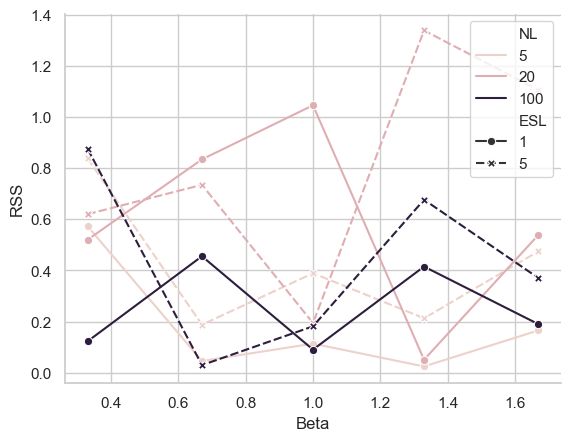

In [59]:
fig, ax = plt.subplots()
sns.lineplot(data=res_df_long, x='Beta', y='RSS', hue='NL', style='ESL', markers=True, ax=ax)
ax.spines[['top', 'right']].set_visible(False)